In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.decomposition import PCA

# 1/ Inner loop: Oja's network
ni input neurons (activity X) projecting on 1 output neuron (activity Y) with weights W.    
  
Parallelized on ns, nd and nr (number of different plasticity rules run at the same time)  
  
size(X) = [nr, nd, ns, ni]   
size(Y) = [nr, nd, ns, no]  
size(W) = [nr, nd, ni, no]   

In [2]:
class Innerloop_OjaNet(): 
    
    def __init__(self, inner_loop_params):
        self.dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.ns = inner_loop_params['n_samples_per_dataset']
        self.ni = len(inner_loop_params['D'])
        self.ne = inner_loop_params['n_epochs']
        self.nd = inner_loop_params['n_datasets']
        self.nr = inner_loop_params['n_rules']
        self.eta = inner_loop_params['eta']
        
        self.Y = torch.zeros((self.nr, self.nd, self.ns, 1), dtype=torch.double, device=self.dev)
        self.W = torch.zeros((self.nr, self.nd, self.ni, 1), dtype=torch.double, device=self.dev)
        
        #blow up handling
        self.blow_up =  [self.ne for i in range(self.nr)] #epoch at which the nets blew up (n_ep = no blow up) 
        self.not_blown = [i for i in range(self.nr)] #dimensions which did not blow up yet
        self.a_blow = inner_loop_params['a_blow']
        self.b_blow = inner_loop_params['b_blow']
        
        #input datasets
        self.D = inner_loop_params['D']
        self.X, self.pcs = generate_datasets_Gaussian(self.ns, self.nd, self.nr, self.ni, self.D, self.dev)
        
    
    
    def reset(self):
        self.Y = torch.zeros((self.nr, self.nd, self.ns, 1), dtype=torch.double, device=self.dev)
        
        #initialise the weights
        aux = 0.1*torch.randn([self.nd, self.ni, 1], dtype=torch.double, device=self.dev)
        self.W = aux.repeat(self.nr,1,1,1)
        
        #blow up handling
        self.blow_up =  [self.ne for i in range(self.nr)] #epoch at which the nets blew up (n_ep = no blow up) 
        self.not_blown = [i for i in range(self.nr)] #dimensions which did not blow up yet
    
        
        
    def forward(self):
        self.Y = torch.einsum("rdsi,rdio->rdso", self.X, self.W)
        
    
    
    def train(self, A): 
        A = torch.tensor(A, dtype=torch.double, device=self.dev)
        for epoch_num in range(self.ne):
            self.forward()
            
            #forward plasticity rule (weights between layer 1 and 2, target = Oja's rule) 
            self.W += self.eta*torch.sum(G(A, self.X, self.Y, self.W, self.dev), 2)/self.ns
            
            #handle blow-ups
            if not torch.equal(self.W,self.W): #nan != nan: there is a nan somewhere (ie blow up). Fast to compute
                dim_to_remove = []
                for r_num in self.not_blown:
                    if not torch.equal(self.W[r_num, :, :], self.W[r_num, :, :]):
                        self.blow_up[r_num] = epoch_num
                        dim_to_remove.append(r_num)
                self.not_blown = [x for x in self.not_blown if x not in dim_to_remove]
                
        for r_num in self.not_blown: #check for "almost blow ups" at the end of training (almost nan), which can screw up the grad
            dim_to_remove = []
            if torch.max(self.W[r_num]).item() > 100000/self.ns:
                self.blow_up[r_num] = self.ne - 1
                dim_to_remove.append(r_num)
        self.not_blown = [x for x in self.not_blown if x not in dim_to_remove]     
        
        
    
    def score(self, A):
        self.reset()
        self.train(A)
        self.has_blown_up = False
        err_mean_pca = [0]*self.nr
        for r_num in range(self.nr):
            if self.blow_up[r_num] < self.ne: # blow up on this perturbation of A
                self.has_blown_up = True
                err_mean_pca[r_num] = self.a_blow*(self.ne - self.blow_up[r_num])/(self.ne) + self.b_blow
            else:
                aux = self.nd
                for d_num in range(self.nd):
                    err_mean_pca[r_num] += (min(torch.norm(self.pcs[d_num, 0, :] - self.W[r_num, d_num, :, 0]).item(), torch.norm(self.pcs[d_num, 0, :] + self.W[r_num, d_num, :, 0]).item()))/aux
        return(err_mean_pca)
    
    
    
    def check_blow_up(self):
        return(self.has_blown_up)
    
    
    
    def print(self):
        print(""); print("Parameters for InnerLoop_OjaNet:")
        print("ni=" + str(self.ni) + " ne=" + str(self.ne) + " ns=" + str(self.ns) + \
            " nd=" + str(self.nd) + " nr=" + str(self.nr) + " eta=" + str(self.eta) + \
            " dev=" + str(self.dev) + " a_blow=" + str(self.a_blow) + " b_blow=" + str(self.b_blow)); print("")
              
            
            
    def info(self):
        print(""); print("Information on InnerLoop_OjaNet:")
        print("ni input neurons (activity X) projecting on 1 output neuron (activity Y) with weights W.")
        print("Parallelized on ns, nd and nr (number of different plasticity rules run at the same time)")
        print("size(X) = [nr, nd, ns, ni], size(Y) = [nr, nd, ns, no], size(W) = [nr, nd, ni, no]")
        print("Convention: A = [nr, lr] lr = 27 for 2nd order Taylor")
        print("datasets generated from randomly rotated Gaussian from a diagonal matrix D. datasets fixed at the beginning of meta optimization");print("")  

## 1.2/ Auxilliary functions for innerloop

### 1.2.1/ Plotting

In [3]:
def compute_angle_hist(A_hist, l_A, n_meta_it):
    angle_hist_Oja = np.zeros(n_meta_it)
    A_Oja = np.array([0,0,0,0,0,0,0,(-1),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    for meta_it in range(n_meta_it):
        A_f = A_hist[l_A*meta_it : l_A*meta_it + np.int(l_A)]
        angle_hist_Oja[meta_it] = np.arccos(np.dot(A_f, A_Oja)/((np.linalg.norm(A_f)*np.linalg.norm(A_Oja))))*180/(np.pi)
    return(angle_hist_Oja)
    
    
    
def plot_rule_hist(A_hist, l_A, n_meta_it, linewidth = 2, fontsize = 15, font = 'Arial'):
    fig, ax = plt.subplots(figsize=(2.5, 1.5))
    for dim_num in range(int(l_A/2)):
        col = '#625D5D'
        if dim_num == 12:
            col = '#4863A0'
        elif dim_num == 7:
            col = '#fdb462'
        ax.plot([A_hist[dim_num + l_A*i].item() for i in range(n_meta_it)], color = col, linewidth = linewidth)
    ax.set_ylabel(r'$A$', fontname="arial", fontsize=fontsize , labelpad = 6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)
    ax.tick_params(width=linewidth, labelsize=fontsize, length=2*linewidth)
    ax.set_xticks([0,int(n_meta_it/2), n_meta_it])
    ax.set_xlabel('meta-iterations', fontsize=fontsize, fontname="arial")
    ax.set_xlim([0,n_meta_it])
    for tick in ax.get_yticklabels():
        tick.set_fontname(font)
    for tick in ax.get_xticklabels():
        tick.set_fontname(font)
    
    
    
def plot_loss_hist(loss_hist, l_A, n_meta_it, linewidth = 2, fontsize = 15, font = "Arial"):
    fig, ax = plt.subplots(figsize=(2.5, 1.5))
    ax.plot(loss_hist, linewidth = linewidth, color = '#d95f02')
    ax.set_ylabel(r'$L(A)$', fontname="arial", fontsize=fontsize, labelpad = 0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)
    ax.set_xlim([0,n_meta_it])
    ax.set_xticks([0,int(n_meta_it/2), n_meta_it])
    ax.set_xlim([0,n_meta_it])
    ax.set_xlabel('meta-iterations', fontsize=fontsize, fontname="arial")
    ax.set_ylim([0,np.max(loss_hist)])
    ax.tick_params(width=linewidth, labelsize=fontsize, length=2*linewidth)
    for tick in ax.get_yticklabels():
        tick.set_fontname(font)
    for tick in ax.get_xticklabels():
        tick.set_fontname(font)
    plt.show()
    
    
    
def plot_angle_hist(angle_hist, l_A, n_meta_it, linewidth = 2, fontsize = 15, font = "Arial"):
    fig, ax = plt.subplots(figsize=(2.5, 1.5))
    ax.plot(angle_hist, linewidth = linewidth, color = '#d95f02')
    ax.set_ylabel(r'$A \measuredangle A^{Oja}$ ' '($^{\circ}$)', fontname="arial", fontsize=fontsize, labelpad = 0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)
    ax.set_xlim([0,n_meta_it])
    ax.set_xticks([0,int(n_meta_it/2), n_meta_it])
    ax.set_xlim([0,n_meta_it])
    ax.set_xlabel('meta-iterations', fontsize=fontsize, fontname="arial")
    ax.set_yticks([0,30,60,90])
    ax.set_ylim([0,np.max(angle_hist)])
    ax.tick_params(width=linewidth, labelsize=fontsize, length=2*linewidth)
    for tick in ax.get_yticklabels():
        tick.set_fontname(font)
    for tick in ax.get_xticklabels():
        tick.set_fontname(font)
    plt.show()
    
    
    
def plot_optimization(outerloop):
    angle_hist_Oja = compute_angle_hist(outerloop.rule_hist, outerloop.lr, outerloop.current_meta_it)
    plot_rule_hist(outerloop.rule_hist, outerloop.lr, outerloop.current_meta_it)
    plot_loss_hist(outerloop.loss_hist, outerloop.lr, outerloop.current_meta_it)
    plot_angle_hist(angle_hist_Oja, outerloop.lr, outerloop.current_meta_it)

### 1.2.2/ Plasticity rules

Convention: A = [nr, lr] lr = 27 

In [4]:
def G(A, X, Y, W, dev):
    # parametrized plasticity rule for input layer -> output layer weights
    # A = coefficients of the self.nr plasticity rules tested in parallel

    DW = 0
    ct = 0
    for x in [torch.ones(X.size(), dtype=torch.double, device=dev), X, torch.mul(X,X)]: # (elementwise mult)
        for y in [torch.ones(Y.size(),dtype=torch.double, device=dev), Y, torch.mul(Y,Y)]:
            for w in [torch.ones(W.size(),dtype=torch.double, device=dev), W, torch.mul(W,W)]:
                DW += torch.einsum("r,rdsi,rdso,rdio->rdsio",A[:,ct],x,y,w)
                ct += 1
    return(DW)

### 1.2.3/ Training datasets generation
#### size(X) = [nr, nd, ns, ni] 
nr: number of different plasticity rules tested in parallel  
nd: number of datasets tested  
ns: number of samples per dataset  
ni: number of input neurons in the pca network (= number of dimensions of the ambient space of the datasets)

In [5]:
def generate_datasets_Gaussian(n_samples, n_datasets, n_plast_rules, n_input, D, dev):
    #Xi taken from N(0,transp(Q)*D*Q)
    #D diagonal matrix, will be rotated to become the covariance matrix of the dataset
    
    X = torch.zeros((n_datasets, n_samples, n_input), dtype=torch.double, device=dev)
    for d_num in range(n_datasets):
        A = np.random.rand(n_input, n_input)
        Q, _ = np.linalg.qr(A)  #generate a random rotation to apply to D 
        if np.linalg.det(Q) < 0:
            Q = -Q
        Cov = np.matmul(np.transpose(Q),np.matmul(D, Q)) 
        for s_num in range(n_samples): 
            X[d_num, s_num, :] = torch.tensor(np.random.multivariate_normal([0 for i in range(n_input)], Cov))
    
    #compute & store principal vectors to compare to PCA network performance afterwards
    pcs = np.zeros((n_datasets, n_input, n_input)) #which dataset, which pc, which dim
    for d_num in range(n_datasets):
        pca = PCA()
        pca.fit(X[d_num, :, :].to('cpu').numpy())
        for i_num in range(n_input):
            pcs[d_num, i_num, :] = pca.components_[i_num]
    
    return(X.repeat(n_plast_rules,1,1,1), torch.tensor(pcs, dtype=torch.double, device=dev))   

# 2/ Outer-loop: CMA-ES

In [6]:
class OuterLoop_CMA_ES():
       
    def __init__(self, outer_loop_params, inner_loop_params):
        
        # L1 regularization on plasticity rule parameters
        self.reg = outer_loop_params["reg"]
        
        # optimizer parameters
        self.lr = len(outer_loop_params["A"])
        self.current_meta_it = 0
        if outer_loop_params["lambd"] == "auto":
            self.lambd = int(4 + np.floor(3*np.log(len(outer_loop_params["A"])))) #number of search points in a generation #population size
            print("generation size lambda = " + str(self.lambd))
        else:
            self.lambd = outer_loop_params["lambd"]
        inner_loop_params["n_rules"] = self.lambd + 1 #+1 cuz we will test self.m for plotting purpose in addition
        self.mu = int(np.floor(self.lambd/2)) #number of non negative recombination weights
        wi_aux = np.array([np.log((self.lambd + 1)/2) - np.log(i+1) for i in range(self.lambd)])
        self.mu_eff = np.sum(wi_aux[:self.mu])**2/np.sum(np.multiply(wi_aux[:self.mu], wi_aux[:self.mu]))
        
        # covariance matrix adaptation
        self.c_c = (4 + self.mu_eff/self.lr)/(self.lr + 4 + 2*self.mu_eff/self.lr)
        self.c_1 = 2/((self.lr + 1.3)**2 + self.mu_eff)
        self.c_mu = np.minimum(1 - self.c_1, 2*(self.mu_eff - 2 + 1/self.mu_eff)/((self.lr + 2)**2 + self.mu_eff))
        
        # selection and recombination
        mu_eff_m = np.sum(wi_aux[self.mu+1:])**2/np.sum(np.multiply(wi_aux[self.mu+1:], wi_aux[self.mu+1:]))
        alpha_mu_m = 1 + self.c_1/self.c_mu
        alpha_mu_eff_m = 1 + 2*mu_eff_m/(self.mu_eff + 2)
        alpha_pos_def_m = (1 - self.c_1 - self.c_mu)/(self.lr*self.c_mu)
        sum_wi_aux_pos = 0; sum_wi_aux_neg = 0
        for i in range(self.lambd):
            if wi_aux[i] >= 0:
                sum_wi_aux_pos += wi_aux[i]
            else:
                sum_wi_aux_neg -= wi_aux[i]
            
        self.wi = np.zeros(self.lambd) #recombination weights
        for i in range(self.lambd):
            if wi_aux[i] >= 0:
                self.wi[i] = wi_aux[i]/sum_wi_aux_pos
            else:
                self.wi[i] = wi_aux[i]*np.minimum(alpha_mu_m, np.minimum(alpha_mu_eff_m, alpha_pos_def_m))/sum_wi_aux_neg
                
        # step size control
        self.c_sig = (self.mu_eff + 2)/(self.lr + self.mu_eff + 5)
        self.d_sig = 1 + 2*np.maximum(0, np.sqrt((self.mu_eff - 1)/(self.lr + 1)) - 1) + self.c_sig
        
        
        # optimizer initialisation
        self.C = np.identity(self.lr) #initial covariance matrix
        self.m = outer_loop_params["A"] #initial mean distribution
        self.sigma = outer_loop_params["sigma"] #step size
        self.p_sig= np.zeros(self.lr) # evolution path
        self.p_c = np.zeros(self.lr) # evolution path
        self.chiN = np.sqrt(self.lr)*(1 - 1/(4*self.lr) + 1/(21*(self.lr**2))) #expectation of ||N(0,I)||
        self.innerloop = Innerloop_OjaNet(inner_loop_params)
        
        # for plotting
        self.rule_hist = outer_loop_params["A"] #plot best element of population at each meta-iteration
        self.loss_hist = []  #plot loss assiociated to best element in the population
        self.sigma_init = outer_loop_params["sigma"]

        
        
    def score_population(self, x): #evaluate meta-objective at the points in parameter space in A_pop 
        loss_no_l1 = self.innerloop.score(x)
        l1 = np.multiply([np.linalg.norm(x[i, :],ord = 1).item() for i in range(self.lambd)],self.reg)
        return(loss_no_l1[-1], loss_no_l1[:-1] + l1)
    
    
    
    def run(self, n_meta_it): #CMA-ES optimizer
        initial_meta_it = self.current_meta_it # meta-it is the generation number
        
        while self.current_meta_it < (initial_meta_it + n_meta_it):   
            
            # eigendecomposition of C: C = BDDt(B) 
            D,B = np.linalg.eigh(self.C)
            D = np.diagflat(np.sqrt(D))
            
            # sample new population of search points
            z = np.array([np.random.multivariate_normal([0 for i in range(self.lr)], np.identity(self.lr)) for j in range(self.lambd)])
            y = np.array([np.matmul(B, np.matmul(D, z[i,:])) for i in range(self.lambd)])
            x = self.m + self.sigma*y #x are the new population of rules for this generation (i.e. meta-iteration)
            
            # sort population by ascending score
            x_aux = np.concatenate((x, np.expand_dims(self.m, axis=0))) #get loss(m) for plotting purposes only, m itself not included as an individual in CMA-ES
            loss_current, meta_obj = self.score_population(x_aux)
            x_sorted = np.array([x for _,x in sorted(zip(meta_obj, x), key=lambda pair: pair[0])]) 
            y_sorted = (x_sorted - self.m)/self.sigma
            
            # selection and recombination
            y_w = np.sum(np.array([self.wi[i]*y_sorted[i,:] for i in range(self.mu)]), axis = 0) #step of the distribution mean
            self.m = self.m + 1*self.sigma*y_w #cm = 1, see tuto
            
            # step size control
            d_1 = np.diagflat([1/i for i in np.diagonal(D)])
            C_12 = np.matmul(B, np.matmul(d_1, np.transpose(B)))
            self.p_sig = (1 - self.c_sig)*self.p_sig + np.sqrt(self.c_sig*(2 - self.c_sig)*self.mu_eff)*np.matmul(C_12, y_w)
            self.sigma = self.sigma*np.exp((self.c_sig/self.d_sig)*((np.linalg.norm(self.p_sig)/self.chiN) - 1))
            
            # heaviside function for step size control
            if np.linalg.norm(self.p_sig)/np.sqrt(1 - (1 - self.c_sig)**(2*(self.current_meta_it + 1))) < \
            (1.4 + 2/(self.lr + 1))*self.chiN:
                h_sig = 1
            else:
                h_sig = 0
            
            # covariance matrix adaptation
            self.p_c = (1 - self.c_c)*self.p_c + h_sig*np.sqrt(self.c_c*(2 - self.c_c)*self.mu_eff)*y_w
            wi_o = np.zeros(self.lambd)
            for i in range(self.lambd):
                if self.wi[i] > 0:
                    wi_o[i] = self.wi[i]
                else:
                    wi_o[i] = self.wi[i]*self.lr/(np.linalg.norm(np.matmul(C_12, y_sorted[i,:])))**2
            delta_h_sig = (1 - h_sig)*self.c_c*(2 - self.c_c)
            self.C = (1 + self.c_1*delta_h_sig - self.c_1 - self.c_mu*np.sum(self.wi))*self.C \
            + self.c_1*np.outer(self.p_c, self.p_c) \
            + self.c_mu*np.sum([wi_o[i]*np.outer(y_sorted[i,:], y_sorted[i,:]) for i in range(self.lambd)], axis = 0)

            # keep user informed of meta-optimization progress
            if (self.current_meta_it % 10 == 0):
                print("iteration " + str(self.current_meta_it+1) + "/" + str(initial_meta_it + n_meta_it))
                print("current_loss (without L1 term): " + str(loss_current))
                print("m " + str(self.m))
                print("sigma " + str(self.sigma))
    
            self.current_meta_it += 1  
            self.rule_hist = np.concatenate((self.rule_hist, self.m),0)
            self.loss_hist.append(loss_current)    
    
    
    
    def print(self):
        print(""); print("Parameters for Outerloop_CMA_ES:")
        print("lambd=" + str(self.lambd) + " sigma init=" + str(self.sigma_init) + " reg=" + str(self.reg)); print("")
    
    
    
    def info(self):
        print(""); print("Information on Outerloop_CMA_ES:")
        print("Outer loop using the evolutionnary strategy CMA_ES. Based on The CMA Evolution Strategy: A Tutorial, Nikolaus Hansen, arXiv 2016")
        print("At each generation, new individuals (here plasticity rules) are drawn from N(m,C). Both m (distr mean) and C (covariance matrix) are learnt")
        print("Specific requirements for innerloop: none")
        print("Important parameters:")
        print("lambda: generation size. Can be set automatically depending on n_coeffs of the plasticity rules, but this number is often too small")
        print("sigma: initial step size for both m and C. sigma is adapptative, but initial value should be ~0.3(a-b) if the the estimated search range for the plasticity rules coeffs is [a,b]**lr")
        print("reg: coefficient for L1 regularization")
        print("There are many other parameters, most of them have a strongly recommended value (see tutorial). Go inside code to change them"); print("")

# 3/ Simulation

Note: might be long to run without a gpu, even in 3D

iteration 41/70
current_loss (without L1 term): 0.15265775572537185
m [ 0.01529939 -0.3359151   0.20550462 -0.05299366  0.03179022 -0.07061458
 -0.07736065 -0.5352426  -0.03380591 -0.13645167  0.04545156 -0.01827312
  0.83459404  0.0786112  -0.11003706 -0.0395699   0.00990671 -0.09839215
  0.10403849  0.13038166  0.03277136  0.03571126  0.05472931  0.16475481
 -0.02607325 -0.09739559 -0.03599075]
sigma 0.12036279743793017
iteration 51/70
current_loss (without L1 term): 0.11970476848615695
m [ 0.02875844 -0.16686628  0.03415463 -0.02985234  0.01368029 -0.0539198
 -0.05940825 -0.66552991 -0.06140266 -0.05484922  0.05392365 -0.00937618
  0.77561038  0.04418715 -0.08134357  0.05742721  0.02325182 -0.05058116
  0.03597657  0.23699115  0.02786972 -0.05776864  0.04203523  0.17086111
  0.00774423 -0.0836632  -0.0019515 ]
sigma 0.0963875675488432
iteration 61/70
current_loss (without L1 term): 0.08666511364990798
m [ 0.00290655 -0.05163658 -0.0559124  -0.02521506  0.03256085 -0.08265091
 -0.010

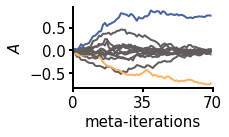

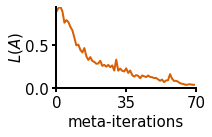

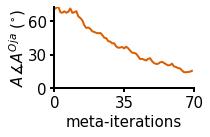


Parameters for Outerloop_CMA_ES:
lambd=50 sigma init=0.1 reg=0.1


Information on Outerloop_CMA_ES:
Outer loop using the evolutionnary strategy CMA_ES. Based on The CMA Evolution Strategy: A Tutorial, Nikolaus Hansen, arXiv 2016
At each generation, new individuals (here plasticity rules) are drawn from N(m,C). Both m (distr mean) and C (covariance matrix) are learnt
Specific requirements for innerloop: none
Important parameters:
lambda: generation size. Can be set automatically depending on n_coeffs of the plasticity rules, but this number is often too small
sigma: initial step size for both m and C. sigma is adapptative, but initial value should be ~0.3(a-b) if the the estimated search range for the plasticity rules coeffs is [a,b]**lr
reg: coefficient for L1 regularization
There are many other parameters, most of them have a strongly recommended value (see tutorial). Go inside code to change them


Information on InnerLoop_OjaNet:
ni input neurons (activity X) projecting on 1 output

In [11]:
###### innerloop_params for Innerloop_OjaNet and initial plasticity rule ######

n_samples_per_dataset = 100; n_epochs = 200; eta = 1/10; n_datasets = 20
a_blow = 1; b_blow = 1
D3 = np.diag([1,0.5,0])
D5 = np.diag([1,0.7,0.2,0.1,0])
D100 = np.zeros((100,100)); D100[0,0] = 1; D100[1,1] = 0.9; D100[2,2] = 0.8; D100[3,3] = 0.7; D100[4,4] = 0.6; D100[5,5] = 0.5
D_chosen = D3; n_input = 3

# initial plasticity rule for outerloop
A_oja = np.array([0,0,0,0,0,0,0,(-1),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
A_rand = np.random.normal(loc = 0, scale =0.01, size=len(A_oja))

inner_loop_params = dict([('n_samples_per_dataset', n_samples_per_dataset), ('D', D_chosen), ('n_epochs', n_epochs), \
('n_datasets', n_datasets), ('n_input', n_input), ('eta', eta), \
('a_blow', a_blow), ('b_blow', b_blow)])


###### outer_loop_params for OuterLoop_CMA_ES, initial plasticity rule specified in innerloop ######

n_meta_it = 50; reg = 0.1; sigma = 0.1; lambd = 50

outer_loop_params = dict([('A', A_rand),  ("sigma", sigma), ("reg", reg), ("lambd", lambd)])


###### Start and plot the optimization ######

outerloop = OuterLoop_CMA_ES(outer_loop_params, inner_loop_params)
start = time.time()
outerloop.run(n_meta_it) 
print("Execution took " + str(np.round(time.time()-start,2)) + "s")
plot_optimization(outerloop)
outerloop.print()
outerloop.info()
outerloop.innerloop.info()
outerloop.innerloop.print()